In [4]:
!pip install scikit-learn

   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
   - -------------------------------------- 0.5/11.0 MB 4.2 MB/s eta 0:00:03
   ------------------------- -------------- 7.1/11.0 MB 22.9 MB/s eta 0:00:01
   ---------------------------------------- 11.0/11.0 MB 25.4 MB/s eta 0:00:00


In [5]:
%load_ext autoreload
%autoreload 2
    
from data import get_dataset, data_to_sequences, data_to_ratequences, data_to_ratequences_splitted
from eval_utils import sasrec_model_scoring

from time import time
from functools import reduce
import uuid
from tqdm import tqdm
import os

import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader

from model import SASRec
from data import get_dataset, data_to_sequences, SequentialDataset
from utils import topn_recommendations, downvote_seen_items
from eval_utils import model_evaluate, sasrec_model_scoring, get_test_scores

from sklearn.linear_model import LogisticRegression
from train import build_sasrec_model

from typing import Dict
from typing import Optional
from typing import Union

from sklearn.utils import check_random_state
from sklearn.utils import check_scalar

import matplotlib.pyplot as plt

os.environ['CUDA_VISIBLE_DEVICES'] = '0'
device='cuda'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data

In [210]:
training_temp, data_description_temp, testset_valid_temp, testset, holdout_valid_temp, _ = get_dataset(splitting='temporal_full',
                                                                                     q=0.8)
data_description_temp

/workspace/mnt/local/data/dalibraa/sasrec_rl/RECE/utils.py:10: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.loc[:, field] = idx
/workspace/mnt/local/data/dalibraa/sasrec_rl/RECE/utils.py:10: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.loc[:, field] = idx


Filtered 115 invalid observations.
Filtered 11 invalid observations.
Filtered 4 invalid observations.


{'users': 'userid',
 'items': 'itemid',
 'order': 'timestamp',
 'n_users': 5400,
 'n_items': 3658}

In [211]:
testset['rating'] = (testset['rating'] >= 4) * 1
testset.head()

In [7]:
training_full, data_description_full, testset_valid_full, _, holdout_valid_full, _ = get_dataset(splitting='full',
                                                                                     q=0.8)
data_description_full

userid         1783
itemid         3511
rating            5
timestamp    110948
dtype: int64
Filtered 115 invalid observations.


/workspace/mnt/local/data/dalibraa/sasrec_rl/RECE/utils.py:10: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.loc[:, field] = idx
/workspace/mnt/local/data/dalibraa/sasrec_rl/RECE/utils.py:10: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.loc[:, field] = idx


Filtered 11 invalid observations.
Filtered 4 invalid observations.
userid         1783
itemid         3464
rating            5
timestamp    110850
dtype: int64
Filtered 107 invalid observations.
Filtered 8 invalid observations.
Filtered 13 invalid observations.
Filtered 2 invalid observations.


{'users': 'userid',
 'items': 'itemid',
 'order': 'timestamp',
 'n_users': 5400,
 'n_items': 3658}

## Train SASRec models

In [569]:
base_config1 = dict(
    manual_seed = 123,
    sampler_seed = 123,
    num_epochs = 3, #3 10 22 100&dropout0.9&hd32&bs1000
    maxlen = 100,
    hidden_units = 64,
    dropout_rate = 0.3,
    num_blocks = 2,
    num_heads = 1,
    batch_size = 128,
    learning_rate = 1e-3,
    fwd_type = 'ce',
    l2_emb = 0,
    patience = 10,
    skip_epochs = 1,
    n_neg_samples=0,
    sampling='no_sampling'
)

In [570]:
base_config2 = dict(
    manual_seed = 123,
    sampler_seed = 123,
    num_epochs = 100,
    maxlen = 250,
    hidden_units = 64,
    dropout_rate = 0.3,
    num_blocks = 2,
    num_heads = 1,
    batch_size = 128,
    learning_rate = 1e-3,
    fwd_type = 'ce',
    l2_emb = 0,
    patience = 10,
    skip_epochs = 1,
    n_neg_samples=0,
    sampling='no_sampling'
)

In [18]:
model_e = build_sasrec_model(base_config1, training_temp, data_description_temp, testset_valid_temp, holdout_valid_temp, device, task=None, log=None)

  1%|▊                                                                                  | 1/100 [00:21<34:39, 21.01s/it]

Epoch 0, NDCG@10: 0.020857005225796105


  2%|█▋                                                                                 | 2/100 [00:39<31:46, 19.45s/it]

Epoch 1, NDCG@10: 0.022605316616854287


  3%|██▍                                                                                | 3/100 [00:57<30:44, 19.02s/it]

Epoch 2, NDCG@10: 0.0279980519704876


  4%|███▎                                                                               | 4/100 [01:16<30:11, 18.87s/it]

Epoch 3, NDCG@10: 0.057676023728053465


  5%|████▏                                                                              | 5/100 [01:34<29:33, 18.66s/it]

Epoch 4, NDCG@10: 0.07885793069145355


  6%|████▉                                                                              | 6/100 [01:53<29:10, 18.62s/it]

Epoch 5, NDCG@10: 0.09410784788872177


  7%|█████▊                                                                             | 7/100 [02:11<28:36, 18.46s/it]

Epoch 6, NDCG@10: 0.10113889186882692


  8%|██████▋                                                                            | 8/100 [02:30<28:44, 18.75s/it]

Epoch 7, NDCG@10: 0.10931073610260532


  9%|███████▍                                                                           | 9/100 [02:49<28:20, 18.68s/it]

Epoch 8, NDCG@10: 0.11497325722357138


 10%|████████▏                                                                         | 10/100 [03:07<27:52, 18.59s/it]

Epoch 9, NDCG@10: 0.12285806476604012


 11%|█████████                                                                         | 11/100 [03:26<27:28, 18.52s/it]

Epoch 10, NDCG@10: 0.12697468031152057


 12%|█████████▊                                                                        | 12/100 [03:44<27:06, 18.48s/it]

Epoch 11, NDCG@10: 0.1293810322289219


 13%|██████████▋                                                                       | 13/100 [04:02<26:45, 18.45s/it]

Epoch 12, NDCG@10: 0.135533148969595


 14%|███████████▍                                                                      | 14/100 [04:21<26:28, 18.47s/it]

Epoch 13, NDCG@10: 0.1375578918480238


 15%|████████████▎                                                                     | 15/100 [04:39<26:09, 18.46s/it]

Epoch 14, NDCG@10: 0.1417444034199188


 16%|█████████████                                                                     | 16/100 [04:58<25:50, 18.46s/it]

Epoch 15, NDCG@10: 0.14203657422153396


 17%|█████████████▉                                                                    | 17/100 [05:16<25:32, 18.46s/it]

Epoch 16, NDCG@10: 0.145513304073232


 18%|██████████████▊                                                                   | 18/100 [05:35<25:12, 18.45s/it]

Epoch 17, NDCG@10: 0.148586647159639


 19%|███████████████▌                                                                  | 19/100 [05:53<24:53, 18.44s/it]

Epoch 18, NDCG@10: 0.14925435836303508


 20%|████████████████▍                                                                 | 20/100 [06:11<24:30, 18.39s/it]

Epoch 19, NDCG@10: 0.1513093116217613


 21%|█████████████████▏                                                                | 21/100 [06:30<24:07, 18.32s/it]

Epoch 20, NDCG@10: 0.14987886363198075


 22%|██████████████████                                                                | 22/100 [06:48<23:48, 18.31s/it]

Epoch 21, NDCG@10: 0.15216147658811288


 23%|██████████████████▊                                                               | 23/100 [07:06<23:30, 18.31s/it]

Epoch 22, NDCG@10: 0.1539484063987084


 24%|███████████████████▋                                                              | 24/100 [07:24<23:10, 18.30s/it]

Epoch 23, NDCG@10: 0.15319104640348036


 25%|████████████████████▌                                                             | 25/100 [07:43<22:50, 18.27s/it]

Epoch 24, NDCG@10: 0.1525867041477849


 26%|█████████████████████▎                                                            | 26/100 [08:01<22:31, 18.26s/it]

Epoch 25, NDCG@10: 0.15315867336495387


 27%|██████████████████████▏                                                           | 27/100 [08:19<22:13, 18.26s/it]

Epoch 26, NDCG@10: 0.1539025567615678


 28%|██████████████████████▉                                                           | 28/100 [08:37<21:53, 18.24s/it]

Epoch 27, NDCG@10: 0.15437393998066337


 29%|███████████████████████▊                                                          | 29/100 [08:56<21:35, 18.25s/it]

Epoch 28, NDCG@10: 0.15577780284558507


 30%|████████████████████████▌                                                         | 30/100 [09:14<21:20, 18.29s/it]

Epoch 29, NDCG@10: 0.15582529606743883


 31%|█████████████████████████▍                                                        | 31/100 [09:33<21:14, 18.47s/it]

Epoch 30, NDCG@10: 0.1548178998125833


 32%|██████████████████████████▏                                                       | 32/100 [09:52<21:12, 18.72s/it]

Epoch 31, NDCG@10: 0.15620733853635815


 33%|███████████████████████████                                                       | 33/100 [10:11<20:59, 18.79s/it]

Epoch 32, NDCG@10: 0.1563971299480122


 34%|███████████████████████████▉                                                      | 34/100 [10:30<20:42, 18.83s/it]

Epoch 33, NDCG@10: 0.15722030679466947


 35%|████████████████████████████▋                                                     | 35/100 [10:49<20:21, 18.79s/it]

Epoch 34, NDCG@10: 0.15668477898695402


 36%|█████████████████████████████▌                                                    | 36/100 [11:07<19:54, 18.66s/it]

Epoch 35, NDCG@10: 0.15730080774423474


 37%|██████████████████████████████▎                                                   | 37/100 [11:26<19:31, 18.59s/it]

Epoch 36, NDCG@10: 0.15692394687247255


 38%|███████████████████████████████▏                                                  | 38/100 [11:44<19:07, 18.51s/it]

Epoch 37, NDCG@10: 0.15753954340954388


 39%|███████████████████████████████▉                                                  | 39/100 [12:02<18:45, 18.44s/it]

Epoch 38, NDCG@10: 0.15612520172783212


 40%|████████████████████████████████▊                                                 | 40/100 [12:21<18:25, 18.43s/it]

Epoch 39, NDCG@10: 0.15713025116040247


 41%|█████████████████████████████████▌                                                | 41/100 [12:39<18:04, 18.38s/it]

Epoch 40, NDCG@10: 0.15915333438133408


 42%|██████████████████████████████████▍                                               | 42/100 [12:57<17:44, 18.36s/it]

Epoch 41, NDCG@10: 0.15675761942439853


 43%|███████████████████████████████████▎                                              | 43/100 [13:15<17:24, 18.33s/it]

Epoch 42, NDCG@10: 0.1583287675118393


 44%|████████████████████████████████████                                              | 44/100 [13:33<17:01, 18.23s/it]

Epoch 43, NDCG@10: 0.15942700734639023


 45%|████████████████████████████████████▉                                             | 45/100 [13:53<16:57, 18.51s/it]

Epoch 44, NDCG@10: 0.160779970278985


 46%|█████████████████████████████████████▋                                            | 46/100 [14:11<16:40, 18.53s/it]

Epoch 45, NDCG@10: 0.15851780925633127


 47%|██████████████████████████████████████▌                                           | 47/100 [14:29<16:17, 18.45s/it]

Epoch 46, NDCG@10: 0.16010303673610515


 48%|███████████████████████████████████████▎                                          | 48/100 [14:48<15:55, 18.37s/it]

Epoch 47, NDCG@10: 0.1602348459505172


 49%|████████████████████████████████████████▏                                         | 49/100 [15:06<15:37, 18.38s/it]

Epoch 48, NDCG@10: 0.16016235333675252


 50%|█████████████████████████████████████████                                         | 50/100 [15:25<15:21, 18.44s/it]

Epoch 49, NDCG@10: 0.1601804227335409


 51%|█████████████████████████████████████████▊                                        | 51/100 [15:43<15:06, 18.49s/it]

Epoch 50, NDCG@10: 0.16001454050515745


 52%|██████████████████████████████████████████▋                                       | 52/100 [16:02<14:45, 18.45s/it]

Epoch 51, NDCG@10: 0.16043955739756252


 53%|███████████████████████████████████████████▍                                      | 53/100 [16:20<14:30, 18.53s/it]

Epoch 52, NDCG@10: 0.16055968482353422


 54%|████████████████████████████████████████████▎                                     | 54/100 [16:39<14:11, 18.50s/it]

Epoch 53, NDCG@10: 0.15951945417796082


 55%|█████████████████████████████████████████████                                     | 55/100 [16:57<13:50, 18.46s/it]

Epoch 54, NDCG@10: 0.16005605679289944


 56%|█████████████████████████████████████████████▉                                    | 56/100 [17:15<13:31, 18.43s/it]

Epoch 55, NDCG@10: 0.16354781186049158


 57%|██████████████████████████████████████████████▋                                   | 57/100 [17:34<13:13, 18.46s/it]

Epoch 56, NDCG@10: 0.15995447047528236


 58%|███████████████████████████████████████████████▌                                  | 58/100 [17:52<12:54, 18.44s/it]

Epoch 57, NDCG@10: 0.16131786200896356


 59%|████████████████████████████████████████████████▍                                 | 59/100 [18:11<12:40, 18.55s/it]

Epoch 58, NDCG@10: 0.1604877619116456


 60%|█████████████████████████████████████████████████▏                                | 60/100 [18:30<12:20, 18.51s/it]

Epoch 59, NDCG@10: 0.16165992644595992


 61%|██████████████████████████████████████████████████                                | 61/100 [18:48<12:05, 18.59s/it]

Epoch 60, NDCG@10: 0.1623682071160085


 62%|██████████████████████████████████████████████████▊                               | 62/100 [19:07<11:43, 18.51s/it]

Epoch 61, NDCG@10: 0.1621123535857456


 63%|███████████████████████████████████████████████████▋                              | 63/100 [19:25<11:22, 18.44s/it]

Epoch 62, NDCG@10: 0.1609481905209318


 64%|████████████████████████████████████████████████████▍                             | 64/100 [19:43<10:59, 18.33s/it]

Epoch 63, NDCG@10: 0.16167435300654845


 65%|█████████████████████████████████████████████████████▎                            | 65/100 [20:01<10:40, 18.31s/it]

Epoch 64, NDCG@10: 0.16145650250751697


 66%|██████████████████████████████████████████████████████                            | 66/100 [20:20<10:24, 18.36s/it]

Epoch 65, NDCG@10: 0.1615092304747052


 67%|██████████████████████████████████████████████████████▉                           | 67/100 [20:38<10:06, 18.38s/it]

Epoch 66, NDCG@10: 0.1630397523829415


 67%|██████████████████████████████████████████████████████▉                           | 67/100 [20:57<10:19, 18.77s/it]

Epoch 67, NDCG@10: 0.16216106527260318

Peak training memory, mb: 590.51
Training epoches: 68
Training time, m: 20.96


In [19]:
model_D_sasrec = build_sasrec_model(base_config2, training_full, data_description_full, testset_valid_full, holdout_valid_full, device, task=None, log=None)

  1%|▊                                                                                  | 1/100 [00:22<37:26, 22.69s/it]

Epoch 0, NDCG@10: 0.020005648187120625


  2%|█▋                                                                                 | 2/100 [00:43<35:16, 21.60s/it]

Epoch 1, NDCG@10: 0.02108089505976685


  3%|██▍                                                                                | 3/100 [01:04<34:33, 21.37s/it]

Epoch 2, NDCG@10: 0.03764415658880017


  4%|███▎                                                                               | 4/100 [01:25<34:10, 21.36s/it]

Epoch 3, NDCG@10: 0.061580850623725356


  5%|████▏                                                                              | 5/100 [01:47<33:49, 21.36s/it]

Epoch 4, NDCG@10: 0.08047401049883113


  6%|████▉                                                                              | 6/100 [02:08<33:11, 21.19s/it]

Epoch 5, NDCG@10: 0.09365416143183959


  7%|█████▊                                                                             | 7/100 [02:28<32:35, 21.03s/it]

Epoch 6, NDCG@10: 0.10060445617485406


  8%|██████▋                                                                            | 8/100 [02:49<32:10, 20.99s/it]

Epoch 7, NDCG@10: 0.10736948004462822


  9%|███████▍                                                                           | 9/100 [03:11<32:06, 21.17s/it]

Epoch 8, NDCG@10: 0.11332724817260371


 10%|████████▏                                                                         | 10/100 [03:32<31:40, 21.11s/it]

Epoch 9, NDCG@10: 0.11449859129336569


 11%|█████████                                                                         | 11/100 [03:53<31:08, 21.00s/it]

Epoch 10, NDCG@10: 0.11886933322827727


 12%|█████████▊                                                                        | 12/100 [04:14<30:51, 21.04s/it]

Epoch 11, NDCG@10: 0.12338272977351603


 13%|██████████▋                                                                       | 13/100 [04:35<30:29, 21.03s/it]

Epoch 12, NDCG@10: 0.12654002973956063


 14%|███████████▍                                                                      | 14/100 [04:55<30:02, 20.95s/it]

Epoch 13, NDCG@10: 0.12961132296290703


 15%|████████████▎                                                                     | 15/100 [05:17<29:43, 20.99s/it]

Epoch 14, NDCG@10: 0.1321119010551087


 16%|█████████████                                                                     | 16/100 [05:38<29:28, 21.05s/it]

Epoch 15, NDCG@10: 0.1365879858070935


 17%|█████████████▉                                                                    | 17/100 [05:58<28:58, 20.94s/it]

Epoch 16, NDCG@10: 0.13820571985708535


 18%|██████████████▊                                                                   | 18/100 [06:19<28:31, 20.87s/it]

Epoch 17, NDCG@10: 0.1403270593196572


 19%|███████████████▌                                                                  | 19/100 [06:40<28:05, 20.81s/it]

Epoch 18, NDCG@10: 0.1419857967750751


 20%|████████████████▍                                                                 | 20/100 [07:01<27:55, 20.94s/it]

Epoch 19, NDCG@10: 0.1429205202528379


 21%|█████████████████▏                                                                | 21/100 [07:22<27:33, 20.93s/it]

Epoch 20, NDCG@10: 0.14577233251571808


 22%|██████████████████                                                                | 22/100 [07:43<27:11, 20.91s/it]

Epoch 21, NDCG@10: 0.1478602845399611


 23%|██████████████████▊                                                               | 23/100 [08:04<26:48, 20.89s/it]

Epoch 22, NDCG@10: 0.147158639715641


 24%|███████████████████▋                                                              | 24/100 [08:25<26:27, 20.89s/it]

Epoch 23, NDCG@10: 0.1472430058663355


 25%|████████████████████▌                                                             | 25/100 [08:45<26:05, 20.87s/it]

Epoch 24, NDCG@10: 0.1499254874581166


 26%|█████████████████████▎                                                            | 26/100 [09:06<25:45, 20.88s/it]

Epoch 25, NDCG@10: 0.14969539335784077


 27%|██████████████████████▏                                                           | 27/100 [09:27<25:24, 20.89s/it]

Epoch 26, NDCG@10: 0.14714383719634624


 28%|██████████████████████▉                                                           | 28/100 [09:48<25:05, 20.91s/it]

Epoch 27, NDCG@10: 0.14857206606368503


 29%|███████████████████████▊                                                          | 29/100 [10:09<24:43, 20.89s/it]

Epoch 28, NDCG@10: 0.14851106005127468


 30%|████████████████████████▌                                                         | 30/100 [10:30<24:32, 21.03s/it]

Epoch 29, NDCG@10: 0.14870178780678822


 31%|█████████████████████████▍                                                        | 31/100 [10:51<24:12, 21.05s/it]

Epoch 30, NDCG@10: 0.14824463363103993


 32%|██████████████████████████▏                                                       | 32/100 [11:12<23:49, 21.02s/it]

Epoch 31, NDCG@10: 0.1505458997900727


 33%|███████████████████████████                                                       | 33/100 [11:33<23:25, 20.98s/it]

Epoch 32, NDCG@10: 0.15028414792043487


 34%|███████████████████████████▉                                                      | 34/100 [11:54<22:57, 20.86s/it]

Epoch 33, NDCG@10: 0.14965909789038814


 35%|████████████████████████████▋                                                     | 35/100 [12:15<22:46, 21.03s/it]

Epoch 34, NDCG@10: 0.14961931548297142


 36%|█████████████████████████████▌                                                    | 36/100 [12:36<22:21, 20.96s/it]

Epoch 35, NDCG@10: 0.1500767647558091


 37%|██████████████████████████████▎                                                   | 37/100 [12:57<21:57, 20.91s/it]

Epoch 36, NDCG@10: 0.15208555188253786


 38%|███████████████████████████████▏                                                  | 38/100 [13:18<21:38, 20.95s/it]

Epoch 37, NDCG@10: 0.15069764701049745


 39%|███████████████████████████████▉                                                  | 39/100 [13:39<21:13, 20.87s/it]

Epoch 38, NDCG@10: 0.152210343029548


 40%|████████████████████████████████▊                                                 | 40/100 [13:59<20:48, 20.81s/it]

Epoch 39, NDCG@10: 0.1527861613596081


 41%|█████████████████████████████████▌                                                | 41/100 [14:20<20:29, 20.83s/it]

Epoch 40, NDCG@10: 0.1515335286142276


 42%|██████████████████████████████████▍                                               | 42/100 [14:41<20:07, 20.81s/it]

Epoch 41, NDCG@10: 0.1533752469264598


 43%|███████████████████████████████████▎                                              | 43/100 [15:02<19:47, 20.84s/it]

Epoch 42, NDCG@10: 0.14997547774629025


 44%|████████████████████████████████████                                              | 44/100 [15:23<19:27, 20.84s/it]

Epoch 43, NDCG@10: 0.154764746437385


 45%|████████████████████████████████████▉                                             | 45/100 [15:44<19:16, 21.02s/it]

Epoch 44, NDCG@10: 0.15280765855251513


 46%|█████████████████████████████████████▋                                            | 46/100 [16:05<18:58, 21.08s/it]

Epoch 45, NDCG@10: 0.15419682159023237


 47%|██████████████████████████████████████▌                                           | 47/100 [16:26<18:35, 21.06s/it]

Epoch 46, NDCG@10: 0.15338174253866813


 48%|███████████████████████████████████████▎                                          | 48/100 [16:47<18:06, 20.89s/it]

Epoch 47, NDCG@10: 0.15481261213903483


 49%|████████████████████████████████████████▏                                         | 49/100 [17:08<17:49, 20.98s/it]

Epoch 48, NDCG@10: 0.1544219968090963


 50%|█████████████████████████████████████████                                         | 50/100 [17:29<17:28, 20.97s/it]

Epoch 49, NDCG@10: 0.1563492806967476


 51%|█████████████████████████████████████████▊                                        | 51/100 [17:50<17:07, 20.97s/it]

Epoch 50, NDCG@10: 0.15609191308946138


 52%|██████████████████████████████████████████▋                                       | 52/100 [18:11<16:43, 20.91s/it]

Epoch 51, NDCG@10: 0.1544387224262863


 53%|███████████████████████████████████████████▍                                      | 53/100 [18:32<16:24, 20.96s/it]

Epoch 52, NDCG@10: 0.15402962171771198


 54%|████████████████████████████████████████████▎                                     | 54/100 [18:53<16:02, 20.93s/it]

Epoch 53, NDCG@10: 0.15678889629629925


 55%|█████████████████████████████████████████████                                     | 55/100 [19:14<15:41, 20.93s/it]

Epoch 54, NDCG@10: 0.15803024827740972


 56%|█████████████████████████████████████████████▉                                    | 56/100 [19:35<15:22, 20.97s/it]

Epoch 55, NDCG@10: 0.15559099862004655


 57%|██████████████████████████████████████████████▋                                   | 57/100 [19:56<15:00, 20.94s/it]

Epoch 56, NDCG@10: 0.15568153926385164


 58%|███████████████████████████████████████████████▌                                  | 58/100 [20:16<14:39, 20.93s/it]

Epoch 57, NDCG@10: 0.15676263575711183


 59%|████████████████████████████████████████████████▍                                 | 59/100 [20:37<14:15, 20.87s/it]

Epoch 58, NDCG@10: 0.15475301752368723


 60%|█████████████████████████████████████████████████▏                                | 60/100 [20:58<13:51, 20.79s/it]

Epoch 59, NDCG@10: 0.15883641473032173


 61%|██████████████████████████████████████████████████                                | 61/100 [21:19<13:31, 20.80s/it]

Epoch 60, NDCG@10: 0.15779933276061173


 62%|██████████████████████████████████████████████████▊                               | 62/100 [21:40<13:13, 20.87s/it]

Epoch 61, NDCG@10: 0.15772447578997634


 63%|███████████████████████████████████████████████████▋                              | 63/100 [22:00<12:52, 20.87s/it]

Epoch 62, NDCG@10: 0.15773565644642598


 64%|████████████████████████████████████████████████████▍                             | 64/100 [22:21<12:31, 20.86s/it]

Epoch 63, NDCG@10: 0.15738690445445247


 65%|█████████████████████████████████████████████████████▎                            | 65/100 [22:43<12:14, 20.98s/it]

Epoch 64, NDCG@10: 0.15552985188948237


 66%|██████████████████████████████████████████████████████                            | 66/100 [23:03<11:49, 20.88s/it]

Epoch 65, NDCG@10: 0.15982451311970214


 67%|██████████████████████████████████████████████████████▉                           | 67/100 [23:24<11:29, 20.89s/it]

Epoch 66, NDCG@10: 0.1573811538106219


 68%|███████████████████████████████████████████████████████▊                          | 68/100 [23:45<11:10, 20.95s/it]

Epoch 67, NDCG@10: 0.1590579364078356


 69%|████████████████████████████████████████████████████████▌                         | 69/100 [24:07<10:59, 21.29s/it]

Epoch 68, NDCG@10: 0.1585310080289338


 70%|█████████████████████████████████████████████████████████▍                        | 70/100 [24:29<10:43, 21.44s/it]

Epoch 69, NDCG@10: 0.1585051735595171


 71%|██████████████████████████████████████████████████████████▏                       | 71/100 [24:51<10:25, 21.56s/it]

Epoch 70, NDCG@10: 0.16038802871639912


 72%|███████████████████████████████████████████████████████████                       | 72/100 [25:13<10:05, 21.63s/it]

Epoch 71, NDCG@10: 0.15910326462481225


 73%|███████████████████████████████████████████████████████████▊                      | 73/100 [25:34<09:44, 21.66s/it]

Epoch 72, NDCG@10: 0.15852264220913195


 74%|████████████████████████████████████████████████████████████▋                     | 74/100 [25:57<09:27, 21.82s/it]

Epoch 73, NDCG@10: 0.1591247286322372


 75%|█████████████████████████████████████████████████████████████▌                    | 75/100 [26:18<09:03, 21.73s/it]

Epoch 74, NDCG@10: 0.15872663032377932


 76%|██████████████████████████████████████████████████████████████▎                   | 76/100 [26:40<08:44, 21.84s/it]

Epoch 75, NDCG@10: 0.15985462545080262


 77%|███████████████████████████████████████████████████████████████▏                  | 77/100 [27:03<08:25, 21.97s/it]

Epoch 76, NDCG@10: 0.15956411388371755


 78%|███████████████████████████████████████████████████████████████▉                  | 78/100 [27:25<08:05, 22.06s/it]

Epoch 77, NDCG@10: 0.15840692688401242


 79%|████████████████████████████████████████████████████████████████▊                 | 79/100 [27:47<07:44, 22.11s/it]

Epoch 78, NDCG@10: 0.1591548830229335


 80%|█████████████████████████████████████████████████████████████████▌                | 80/100 [28:09<07:20, 22.04s/it]

Epoch 79, NDCG@10: 0.15811623938642463


 81%|██████████████████████████████████████████████████████████████████▍               | 81/100 [28:31<06:57, 21.98s/it]

Epoch 80, NDCG@10: 0.1603564134018594


 82%|███████████████████████████████████████████████████████████████████▏              | 82/100 [28:53<06:36, 22.04s/it]

Epoch 81, NDCG@10: 0.16047337672048387


 83%|████████████████████████████████████████████████████████████████████              | 83/100 [29:15<06:15, 22.06s/it]

Epoch 82, NDCG@10: 0.1599611892694863


 84%|████████████████████████████████████████████████████████████████████▉             | 84/100 [29:37<05:50, 21.92s/it]

Epoch 83, NDCG@10: 0.1580318786598522


 85%|█████████████████████████████████████████████████████████████████████▋            | 85/100 [29:58<05:28, 21.87s/it]

Epoch 84, NDCG@10: 0.16045452810873392


 86%|██████████████████████████████████████████████████████████████████████▌           | 86/100 [30:20<05:05, 21.85s/it]

Epoch 85, NDCG@10: 0.15810839702319285


 87%|███████████████████████████████████████████████████████████████████████▎          | 87/100 [30:42<04:43, 21.79s/it]

Epoch 86, NDCG@10: 0.16023008755752796


 88%|████████████████████████████████████████████████████████████████████████▏         | 88/100 [31:04<04:21, 21.83s/it]

Epoch 87, NDCG@10: 0.16022344623728957


 89%|████████████████████████████████████████████████████████████████████████▉         | 89/100 [31:26<04:00, 21.87s/it]

Epoch 88, NDCG@10: 0.15988122291552004


 90%|█████████████████████████████████████████████████████████████████████████▊        | 90/100 [31:47<03:38, 21.80s/it]

Epoch 89, NDCG@10: 0.16137811036708152


 91%|██████████████████████████████████████████████████████████████████████████▌       | 91/100 [32:09<03:15, 21.67s/it]

Epoch 90, NDCG@10: 0.15866347556959917


 92%|███████████████████████████████████████████████████████████████████████████▍      | 92/100 [32:31<02:54, 21.77s/it]

Epoch 91, NDCG@10: 0.1603840602291274


 93%|████████████████████████████████████████████████████████████████████████████▎     | 93/100 [32:53<02:32, 21.77s/it]

Epoch 92, NDCG@10: 0.15938868276776816


 94%|█████████████████████████████████████████████████████████████████████████████     | 94/100 [33:13<02:08, 21.41s/it]

Epoch 93, NDCG@10: 0.15967210186997366


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 95/100 [33:34<01:45, 21.12s/it]

Epoch 94, NDCG@10: 0.1591514982522995


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 96/100 [33:54<01:24, 21.01s/it]

Epoch 95, NDCG@10: 0.1608350592776184


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 97/100 [34:15<01:03, 21.02s/it]

Epoch 96, NDCG@10: 0.1597862528490172


 98%|████████████████████████████████████████████████████████████████████████████████▎ | 98/100 [34:36<00:41, 20.97s/it]

Epoch 97, NDCG@10: 0.16087233314939192


 99%|█████████████████████████████████████████████████████████████████████████████████▏| 99/100 [34:57<00:20, 21.00s/it]

Epoch 98, NDCG@10: 0.15925981540697934


100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [35:18<00:00, 21.18s/it]

Epoch 99, NDCG@10: 0.15936497442816644

Peak training memory, mb: 1313.37
Training epoches: 100
Training time, m: 35.31


## RIS

In [156]:
def build_model_D(training_D, model_D_sasrec, n, data_description):
    model_D_sasrec.eval()
    seqs_padded = []
    actions = []
    
    full_sequences = data_to_sequences(training_D, data_description)
    for _, h in tqdm(full_sequences.items()):

        seqt = h.copy()
        for i in range(len(h)-1):
            actions.append(seqt.pop())
            seqs_padded.append(seqt[-n:])
            
        # subseqs_h = []
        # seqt = h.copy()
        # for i in range(1):
        #     at = seqt.pop()
        #     subseqs_h.append((at, seqt[-n:]))
            
    seqs_padded = [np.pad(arr, (n - len(arr), 0), mode='constant', constant_values=model_D_sasrec.pad_token) for arr in seqs_padded]
    seqs_padded = torch.tensor(seqs_padded, device=device)[:, -model_D_sasrec.pos_emb.num_embeddings:]
    with torch.no_grad():
        states = model_D_sasrec.log2feats(seqs_padded)[:, -1].cpu().detach().numpy()
         
    # должно фититься на всех айтемах (все экшены должны быть в таргете хоть раз)
    model_D = LogisticRegression(multi_class='multinomial', max_iter=100, verbose=1).fit(states, actions) 
    
    return actions

In [ ]:
# model_D = build_model_D(training_full[training_full.userid<40], model_D_sasrec, 3, data_description_full)
# model_D

model_D = build_model_D(training_full, model_D_sasrec, 3, data_description_full)
model_D

6040it [00:01, 4630.32it/s]
/tmp/ipykernel_5047/1415606367.py:21: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:261.)
  seqs_padded = torch.tensor(seqs_padded, device=device)[:, -model_D_sasrec.pos_emb.num_embeddings:]
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =       237510     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.10521D+06    |proj g|=  1.67536D+04


In [237]:
# версия с ревордом на основе рейтингов и с векторизацией скоринга моделей
def score_policy_e(at, seqt, model, device):
    
    with torch.no_grad():

        final_feat = model.log2feats(seqt)[:, -1, :]
        item_embs = model.item_emb.weight
        predictions = item_embs.matmul(final_feat.unsqueeze(-1)).squeeze(-1).detach().cpu()
        
        # predictions = model.score(torch.tensor(seqt, device=device, dtype=torch.long)).detach().cpu()[0]
    
    probas = torch.softmax(predictions, 1)
    
    return probas[torch.arange(probas.size(0)), at]


def score_policy_D(at, seqt, n, model_D, model_D_sasrec, device):
    with torch.no_grad():
        state = model_D_sasrec.log2feats(seqt)[:, -1].cpu().detach().numpy()

    # try:
    #     proba_gt = model_D.predict_proba(state.detach().cpu().numpy().reshape(1, -1))[0, np.where(model_D.classes_ == at)[0][0]]
    # except IndexError:
    #     at = 0
    #     proba_gt = model_D.predict_proba(state.detach().cpu().numpy().reshape(1, -1))[0, at]

    proba = model_D.predict_proba(state)
    proba_gt = proba[np.arange(proba.shape[0]), np.array([np.where(model_D.classes_ == a)[0][0] for a in at])]

    return proba_gt

In [212]:
# версия с ревордом на основе рейтингов и с векторизацией скоринга моделей
def prod_score_subseqs(h, model_D, model_D_sasrec, model_e, n, device):

    # create subseqs with gts
    seqs_padded_e = []
    seqs_padded_D = []
    actions = []
    
    seqt = h.copy()
    for i in range(len(h)-1):
        # at = seqt.pop()
        # subseqs_h.append((at, seqt.copy()))
        actions.append(seqt.pop())
        seqs_padded_e.append(seqt.copy())
        seqs_padded_D.append(seqt[-n:])
    
    maxlen = max([len(i) for i in seqs_padded_e])
    seqs_padded_e = [np.pad(arr, (maxlen - len(arr), 0), mode='constant', constant_values=model_e.pad_token) for arr in seqs_padded_e]
    seqs_padded_e = torch.tensor(seqs_padded_e, device=device)[:, -model_e.pos_emb.num_embeddings:] # model_D_sasrec.pos_emb.num_embeddings чей брать

    seqs_padded_D = [np.pad(arr, (n - len(arr), 0), mode='constant', constant_values=model_D_sasrec.pad_token) for arr in seqs_padded_D]
    seqs_padded_D = torch.tensor(seqs_padded_D, device=device)[:, -model_D_sasrec.pos_emb.num_embeddings:] # model_D_sasrec.pos_emb.num_embeddings чей брать
    
    probas_e = score_policy_e(actions, seqs_padded_e, model_e, device)
    probas_D = score_policy_D(actions, seqs_padded_D, n, model_D, model_D_sasrec, device)
    
    product_one_h = np.divide(probas_e, probas_D).prod() # prod p_e/p_D

    return product_one_h

def RISEstimate(testset,  model_D, model_D_sasrec, model_e, data_description, n=3, gamma=0.98, device='cuda'):
    
    model_D_sasrec.eval() 
    model_e.eval()

    test_sequences = data_to_ratequences(testset, data_description) ###
    # m = len(test_sequences)
    ris = []
    
    for _, (h, r) in tqdm(test_sequences.items()):
    
        product_one_h = prod_score_subseqs(h, model_D, model_D_sasrec, model_e, n, device)
        g = np.sum([gamma**t * r[t] for t in range(len(h)-1)])

        ris.append(g * product_one_h)
    
    return np.array(ris).mean(), np.array(ris)

In [239]:
a, c = RISEstimate(testset[testset.userid < 10], model_D, model_D_sasrec, model_e, data_description_full)
a

9it [00:01,  6.50it/s]


2.3860301603997196e+16

In [238]:
a, c = RISEstimate(testset[testset.userid < 10], model_D, model_D_sasrec, model_e2, data_description_full)
a

9it [00:01,  7.36it/s]


1.0789694491121728e-12

In [244]:
a, c = RISEstimate(testset[testset.userid < 10], model_D, model_D_sasrec, model_e3, data_description_full)
a

9it [00:01,  7.35it/s]


967993678.9527929

In [248]:
a, c = RISEstimate(testset[testset.userid < 10], model_D, model_D_sasrec, model_e4, data_description_full)
a

9it [00:01,  6.80it/s]


48209442238.588234

In [251]:
a, c = RISEstimate(testset[testset.userid < 10], model_D, model_D_sasrec, model_D_sasrec, data_description_full)
a

9it [00:01,  6.66it/s]


2.9726025816482687e+40

In [255]:
a, c = RISEstimate(testset[testset.userid < 10], model_D, model_D_sasrec, model_e5, data_description_full)
a

9it [00:01,  6.17it/s]


6.071471564240192e-17

In [217]:
%%time
a, c = RISEstimate(testset, model_D, model_D_sasrec, model_e, data_description_full)
a

1705it [04:27,  6.38it/s]


CPU times: user 32min 45s, sys: 35min 16s, total: 1h 8min 1s
Wall time: 4min 27s


2.4015342441916635e+98

In [331]:
%%time
a, c = RISEstimate(testset, model_D, model_D_sasrec, model_e2, data_description_full)
a

1705it [04:41,  6.05it/s]

CPU times: user 20min, sys: 45min 6s, total: 1h 5min 7s
Wall time: 4min 42s


8.273065061855564e+43

In [245]:
%%time
a, c = RISEstimate(testset, model_D, model_D_sasrec, model_e3, data_description_full)
a

1705it [04:14,  6.70it/s]


CPU times: user 31min 48s, sys: 33min 23s, total: 1h 5min 11s
Wall time: 4min 15s


1.129656536409366e+64

In [249]:
%%time
a, c = RISEstimate(testset, model_D, model_D_sasrec, model_e4, data_description_full)
a

1705it [04:06,  6.93it/s]


CPU times: user 30min 28s, sys: 32min 31s, total: 1h 2min 59s
Wall time: 4min 6s


2.281626106036791e+89

In [252]:
%%time
a, c = RISEstimate(testset, model_D, model_D_sasrec, model_D_sasrec, data_description_full)
a

1705it [04:22,  6.48it/s]


CPU times: user 32min 22s, sys: 34min 36s, total: 1h 6min 58s
Wall time: 4min 23s


3.2217723980884096e+194

#### Should be D_sasrec > e > e4 > e3 > e2 > e5 

In [256]:
%%time
a, c = RISEstimate(testset, model_D, model_D_sasrec, model_e5, data_description_full)
a

1705it [04:18,  6.59it/s]


CPU times: user 32min 11s, sys: 33min 45s, total: 1h 5min 57s
Wall time: 4min 19s


2.183964848420044e+31

### CIs

In [1016]:
%%time
a1, c1 = RISEstimate(testset, model_D, model_D_sasrec, model_e, data_description_full)
a1

1705it [02:50, 10.00it/s]

CPU times: user 41min 20s, sys: 43min 52s, total: 1h 25min 12s
Wall time: 2min 51s


2.4015342441916635e+98

In [ ]:
%%time
a2, c2 = RISEstimate(testset, model_D, model_D_sasrec, model_e2, data_description_full)
a2

In [1071]:
%%time
a3, c3 = RISEstimate(testset, model_D, model_D_sasrec, model_e3, data_description_full)
a3

1705it [03:16,  8.66it/s]


CPU times: user 28min 43s, sys: 56min 15s, total: 1h 24min 58s
Wall time: 3min 17s


1.129656536409366e+64

In [1187]:
%%time
a4, c4 = RISEstimate(testset, model_D, model_D_sasrec, model_e4, data_description_full)
a4

1705it [03:04,  9.23it/s]


CPU times: user 28min 11s, sys: 51min 54s, total: 1h 20min 5s
Wall time: 3min 6s


2.281626106036791e+89

In [1072]:
%%time
a5, c5 = RISEstimate(testset, model_D, model_D_sasrec, model_D_sasrec, data_description_full)
a5

1705it [03:14,  8.75it/s]


CPU times: user 27min 43s, sys: 53min 1s, total: 1h 20min 45s
Wall time: 3min 15s


3.2217723980884096e+194

In [1073]:
%%time
a6, c6 = RISEstimate(testset, model_D, model_D_sasrec, model_e5, data_description_full)
a6

1705it [03:12,  8.86it/s]


CPU times: user 26min 14s, sys: 53min 5s, total: 1h 19min 20s
Wall time: 3min 13s


2.183964848420044e+31

In [1084]:
def estimate_confidence_interval_by_bootstrap(
    samples: np.ndarray,
    alpha: float = 0.05,
    n_bootstrap_samples: int = 10000,
    random_state: Optional[int] = None,
) -> Dict[str, float]:

    boot_samples = list()
    random_ = check_random_state(random_state)
    for _ in np.arange(n_bootstrap_samples):
        boot_samples.append(np.mean(random_.choice(samples, size=samples.shape[0])))
    lower_bound = np.percentile(boot_samples, 100 * (alpha / 2))
    upper_bound = np.percentile(boot_samples, 100 * (1.0 - alpha / 2))
    return {
        "mean": np.mean(boot_samples),
        f"{100 * (1. - alpha)}% CI (lower)": lower_bound,
        f"{100 * (1. - alpha)}% CI (upper)": upper_bound,
    }

In [1003]:
estimate_e = estimate_confidence_interval_by_bootstrap(c1, n_bootstrap_samples=10000, random_state=123)
estimate_e

{'mean': 2.3892865538647724e+98,
 '95.0% CI (lower)': 7.421881117078248e+84,
 '95.0% CI (upper)': 7.204579962260093e+98}

In [1297]:
random_state = 125
random_ = check_random_state(random_state)
sizes = [100, 200, 500, 750, 1000, 1250, 1500, 1700]
# sizes = [4000, 8000, 16000, 32000, 64000, 128000]

cis = []

for i in sizes:
    cis.append(estimate_confidence_interval_by_bootstrap(np.random.choice(c1, size=i, replace=False), n_bootstrap_samples=10000, random_state=random_state))

In [1208]:
cis3 = []
for i in sizes:
    cis3.append(estimate_confidence_interval_by_bootstrap(np.random.choice(c3, size=i, replace=False), n_bootstrap_samples=10000, random_state=random_state))

In [1230]:
cis4 = []
for i in sizes:
    cis4.append(estimate_confidence_interval_by_bootstrap(np.random.choice(c4, size=i, replace=False), n_bootstrap_samples=10000, random_state=random_state))

In [1191]:
cis5 = []
for i in sizes:
    cis5.append(estimate_confidence_interval_by_bootstrap(np.random.choice(c5, size=i, replace=False), n_bootstrap_samples=10000, random_state=random_state))

In [1088]:
cis6 = []
for i in sizes:
    cis6.append(estimate_confidence_interval_by_bootstrap(np.random.choice(c6, size=i, replace=False), n_bootstrap_samples=10000, random_state=random_state))

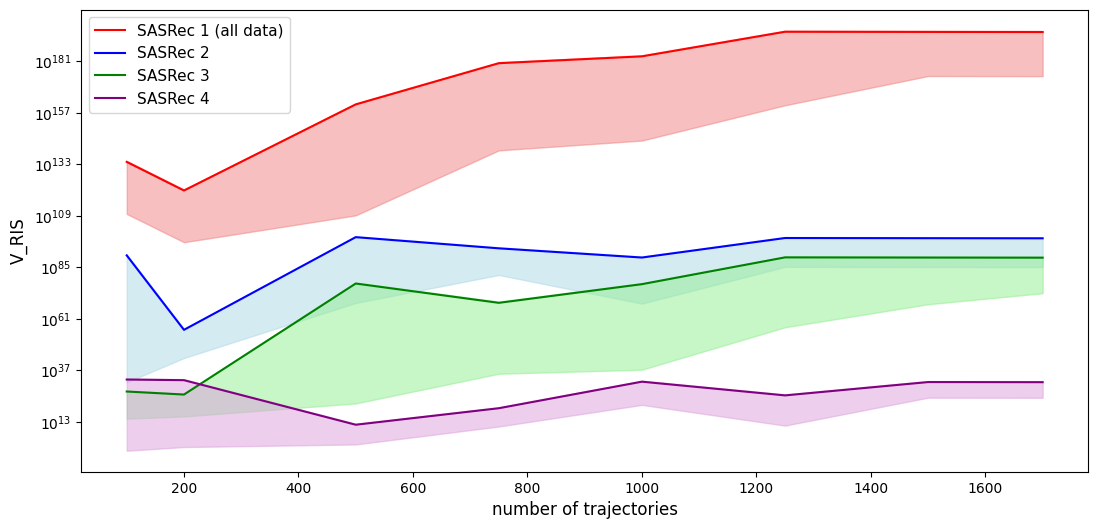

In [1354]:
means1 = [item['mean'] for item in cis]
means3 = [item['mean'] for item in cis4]
means5 = [item['mean'] for item in cis5]
means6 = [item['mean'] for item in cis6]
ci_lowers1 = [item['95.0% CI (lower)'] for item in cis]
ci_uppers1 = [item['95.0% CI (upper)'] for item in cis]
ci_lowers3 = [item['95.0% CI (lower)'] for item in cis4]
ci_uppers3 = [item['95.0% CI (upper)'] for item in cis4]
ci_lowers5 = [item['95.0% CI (lower)'] for item in cis5]
ci_uppers5 = [item['95.0% CI (upper)'] for item in cis5]
ci_lowers6 = [item['95.0% CI (lower)'] for item in cis6]
ci_uppers6 = [item['95.0% CI (upper)'] for item in cis6]

plt.figure(figsize=(13, 6))

x = np.array(sizes)

plt.plot(x, means5, label='SASRec 1 (all data)', color='red')
plt.fill_between(x, ci_lowers5, ci_uppers5, color='lightcoral', alpha=0.5)

plt.plot(x, means1, label='SASRec 2', color='blue')
plt.fill_between(x, ci_lowers1, ci_uppers1, color='lightblue', alpha=0.5)

plt.plot(x, means3, label='SASRec 3', color='green')
plt.fill_between(x, ci_lowers3, ci_uppers3, color='lightgreen', alpha=0.5)

plt.plot(x, means6, label='SASRec 4', color='purple')
plt.fill_between(x, ci_lowers6, ci_uppers6, color='plum', alpha=0.5)

# plt.ylim(min(ci_lowers6) * 0.8, 
#          max(ci_uppers6) * 1.2)

plt.xlabel('number of trajectories', fontsize=12)
plt.ylabel('V_RIS', fontsize=12)
plt.yscale('log')
# plt.title('Means with 95% CI')
plt.legend(fontsize=11)

plt.show()

### Split into trajectories with len <= 22, add history to pi_e

In [1358]:
data_to_ratequences_splitted(testset, data_description_full, trajectory_maxlen=22)

0        ([2935, 1160, 1552, 941, 2117, 1633, 3136, 256...
1        ([2935, 1160, 1552, 941, 2117, 1633, 3136, 256...
2        ([2935, 1160, 1552, 941, 2117, 1633, 3136, 256...
3        ([1090, 1102, 1109, 2479, 1183, 2702, 1117, 10...
4        ([1090, 1102, 1109, 2479, 1183, 2702, 1117, 10...
                               ...                        
10010    ([3570, 3463, 3507, 1344, 2880, 3601, 27, 2466...
10011    ([3570, 3463, 3507, 1344, 2880, 3601, 27, 2466...
10012    ([3570, 3463, 3507, 1344, 2880, 3601, 27, 2466...
10014    ([2932, 2348, 1104, 3092, 3148, 1148, 1160, 18...
10015    ([2932, 2348, 1104, 3092, 3148, 1148, 1160, 18...
Length: 9938, dtype: object

In [1400]:
# версия с ревордом на основе рейтингов и с векторизацией скоринга моделей
def prod_score_subseqs_splitwhistory(h, model_D, model_D_sasrec, model_e, n, device, trajectory_len):

    # create subseqs with gts
    seqs_padded_e = []
    seqs_padded_D = []
    actions = []
    
    seqt = h.copy()

    num_iter = min(len(h)-1, trajectory_len) ### len(h)-1 or len(h) ??????
    for i in range(num_iter):
        # at = seqt.pop()
        # subseqs_h.append((at, seqt.copy()))
        actions.append(seqt.pop())
        seqs_padded_e.append(seqt.copy())
        seqs_padded_D.append(seqt[-n:]) if i <= (num_iter - n) else seqs_padded_D.append(seqt[-num_iter+i:])
        
    
    maxlen = max([len(i) for i in seqs_padded_e])
    seqs_padded_e = [np.pad(arr, (maxlen - len(arr), 0), mode='constant', constant_values=model_e.pad_token) for arr in seqs_padded_e]
    seqs_padded_e = torch.tensor(seqs_padded_e, device=device)[:, -model_e.pos_emb.num_embeddings:] # model_D_sasrec.pos_emb.num_embeddings чей брать

    seqs_padded_D = [np.pad(arr, (n - len(arr), 0), mode='constant', constant_values=model_D_sasrec.pad_token) for arr in seqs_padded_D]
    seqs_padded_D = torch.tensor(seqs_padded_D, device=device)[:, -model_D_sasrec.pos_emb.num_embeddings:] # model_D_sasrec.pos_emb.num_embeddings чей брать
    
    probas_e = score_policy_e(actions, seqs_padded_e, model_e, device)
    probas_D = score_policy_D(actions, seqs_padded_D, n, model_D, model_D_sasrec, device)
    
    product_one_h = np.divide(probas_e, probas_D).prod() # prod p_e/p_D

    return product_one_h

def RISEstimateSplitted(testset,  model_D, model_D_sasrec, model_e, data_description, n=3, gamma=0.98, device='cuda'):
    
    model_D_sasrec.eval() 
    model_e.eval()

    test_sequences = data_to_ratequences_splitted(testset, data_description_full, trajectory_maxlen=22) ###
    # m = len(test_sequences)
    ris = []
    
    for _, (h, r) in tqdm(test_sequences.items()):
    
        product_one_h = prod_score_subseqs_splitwhistory(h, model_D, model_D_sasrec, model_e, n, device, trajectory_len=21)
        g = np.sum([gamma**t * r[t] for t in range(len(h)-1)])

        ris.append(g * product_one_h)
    
    return np.array(ris).mean(), np.array(ris)

In [1401]:
a, c = RISEstimateSplitted(testset[testset.userid < 10], model_D, model_D_sasrec, model_e, data_description_full)
a

40it [00:01, 20.10it/s]


1277460.187540661

In [1402]:
a, c = RISEstimateSplitted(testset[testset.userid < 10], model_D, model_D_sasrec, model_e2, data_description_full)
a

40it [00:01, 21.11it/s]


0.17673352546272694

In [1403]:
a, c = RISEstimateSplitted(testset[testset.userid < 10], model_D, model_D_sasrec, model_e3, data_description_full)
a

40it [00:01, 20.50it/s]


7831.598586344674

In [1404]:
a, c = RISEstimateSplitted(testset[testset.userid < 10], model_D, model_D_sasrec, model_e4, data_description_full)
a

40it [00:01, 20.75it/s]


35597.50160252511

In [1405]:
a, c = RISEstimateSplitted(testset[testset.userid < 10], model_D, model_D_sasrec, model_D_sasrec, data_description_full)
a

40it [00:02, 19.33it/s]


2916134722.5308104

In [1406]:
a, c = RISEstimateSplitted(testset[testset.userid < 10], model_D, model_D_sasrec, model_e5, data_description_full)
a

40it [00:02, 19.36it/s]


0.0034941954245409504

In [1413]:
%%time
a, c11111 = RISEstimateSplitted(testset, model_D, model_D_sasrec, model_e, data_description_full)
a

9938it [07:50, 21.13it/s]


CPU times: user 2h 1min 26s, sys: 2h 9min 9s, total: 4h 10min 35s
Wall time: 7min 51s


2927335356.837807

In [ ]:
%%time
a, c22222 = RISEstimateSplitted(testset, model_D, model_D_sasrec, model_e2, data_description_full)
a

In [1409]:
%%time
a, c33333 = RISEstimateSplitted(testset, model_D, model_D_sasrec, model_e3, data_description_full)
a

46it [00:02, 21.17it/s]

KeyboardInterrupt



In [1414]:
%%time
a, c44444 = RISEstimateSplitted(testset, model_D, model_D_sasrec, model_e4, data_description_full)
a

9938it [07:29, 22.12it/s]


CPU times: user 1h 55min 34s, sys: 2h 3min 48s, total: 3h 59min 23s
Wall time: 7min 30s


531825140.2849749

In [1415]:
%%time
a, c55555 = RISEstimateSplitted(testset, model_D, model_D_sasrec, model_D_sasrec, data_description_full)
a

9938it [07:45, 21.35it/s]


CPU times: user 2h 9s, sys: 2h 7min 47s, total: 4h 7min 56s
Wall time: 7min 46s


3.562812191641325e+17

In [1416]:
%%time
a, c66666 = RISEstimateSplitted(testset, model_D, model_D_sasrec, model_e5, data_description_full)
a

9938it [08:02, 20.61it/s]


CPU times: user 2h 4min 14s, sys: 2h 12min 41s, total: 4h 16min 56s
Wall time: 8min 2s


542698720312.50586

In [1417]:
random_state = 125
random_ = check_random_state(random_state)
sizes = [1400, 2000,3000, 4000, 5000, 6000, 7000, 8000, 9920]
# sizes = [4000, 8000, 16000, 32000, 64000, 128000]

cis111 = []

for i in sizes:
    cis111.append(estimate_confidence_interval_by_bootstrap(np.random.choice(c11111, size=i, replace=False), n_bootstrap_samples=10000, random_state=random_state))

In [1418]:
cis333 = []
for i in sizes:
    cis333.append(estimate_confidence_interval_by_bootstrap(np.random.choice(c44444, size=i, replace=False), n_bootstrap_samples=10000, random_state=random_state))

In [1419]:
cis555 = []
for i in sizes:
    cis555.append(estimate_confidence_interval_by_bootstrap(np.random.choice(c55555, size=i, replace=False), n_bootstrap_samples=10000, random_state=random_state))

In [1420]:
cis666 = []
for i in sizes:
    cis666.append(estimate_confidence_interval_by_bootstrap(np.random.choice(c66666, size=i, replace=False), n_bootstrap_samples=10000, random_state=random_state))

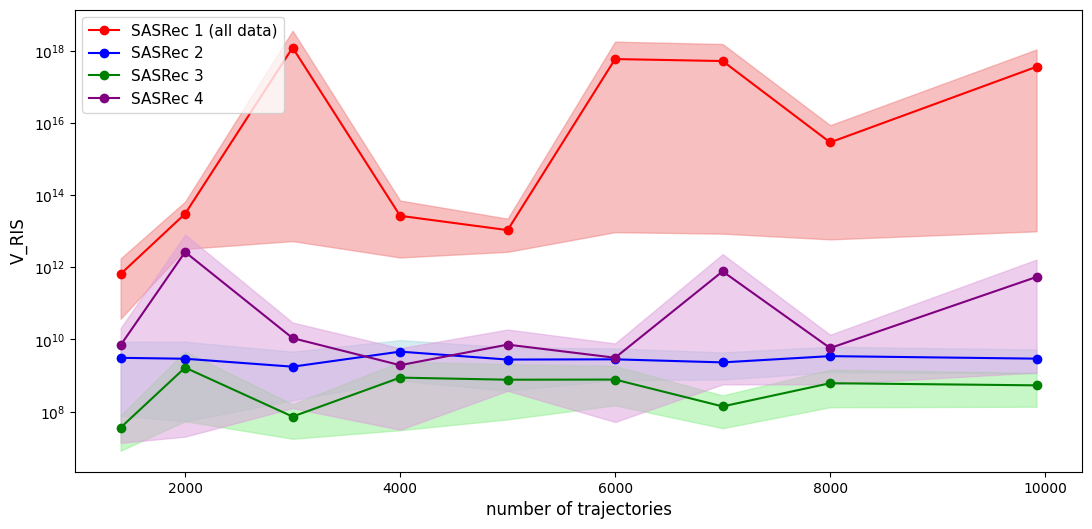

In [1423]:
means111 = [item['mean'] for item in cis111]
means333 = [item['mean'] for item in cis333]
means555 = [item['mean'] for item in cis555]
means666 = [item['mean'] for item in cis666]
ci_lowers111 = [item['95.0% CI (lower)'] for item in cis111]
ci_uppers111 = [item['95.0% CI (upper)'] for item in cis111]
ci_lowers333 = [item['95.0% CI (lower)'] for item in cis333]
ci_uppers333 = [item['95.0% CI (upper)'] for item in cis333]
ci_lowers555 = [item['95.0% CI (lower)'] for item in cis555]
ci_uppers555 = [item['95.0% CI (upper)'] for item in cis555]
ci_lowers666 = [item['95.0% CI (lower)'] for item in cis666]
ci_uppers666 = [item['95.0% CI (upper)'] for item in cis666]

plt.figure(figsize=(13, 6))

x = np.array(sizes)

plt.plot(x, means555, 'o-', label='SASRec 1 (all data)', color='red')
plt.fill_between(x, ci_lowers555, ci_uppers555, color='lightcoral', alpha=0.5)

plt.plot(x, means111, 'o-', label='SASRec 2', color='blue')
plt.fill_between(x, ci_lowers111, ci_uppers111, color='lightblue', alpha=0.5)

plt.plot(x, means333, 'o-', label='SASRec 3', color='green')
plt.fill_between(x, ci_lowers333, ci_uppers333, color='lightgreen', alpha=0.5)

plt.plot(x, means666, 'o-', label='SASRec 4', color='purple')
plt.fill_between(x, ci_lowers666, ci_uppers666, color='plum', alpha=0.5)

plt.xlabel('number of trajectories', fontsize=12)
plt.ylabel('V_RIS', fontsize=12)
plt.yscale('log')
# plt.title('Means with 95% CI')
plt.legend(fontsize=11)

plt.show()